# Orbit Computation

This tutorial demonstrates how to generate satellite orbits using various models.

## Setup

In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go

from ostk.physics.units import Length
from ostk.physics.units import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.time import DateTime
from ostk.physics import Environment

from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory.orbit.models import Kepler
from ostk.astrodynamics.trajectory.orbit.models.kepler import COE
from ostk.astrodynamics.trajectory.orbit.models import SGP4
from ostk.astrodynamics.trajectory.orbit.models.sgp4 import TLE

from ostk.astrodynamics.utilities import convert_state
from ostk.astrodynamics.display import create_2d_map, create_3d_globe

---

## SGP4

### Computation

In [2]:
environment = Environment.default()

Create a Classical Orbital Element (COE) set:

In [3]:
a = Length.kilometers(7000.0)
e = 0.0001
i = Angle.degrees(35.0)
raan = Angle.degrees(40.0)
aop = Angle.degrees(45.0)
nu = Angle.degrees(50.0)

coe = COE(a, e, i, raan, aop, nu)

Setup a Keplerian orbital model:

In [4]:
epoch = Instant.date_time(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC)
earth = environment.access_celestial_object_with_name("Earth")

keplerian_model = Kepler(coe, epoch, earth, Kepler.PerturbationType.No)

Create a Two-Line Element (TLE) set:

In [5]:
tle = TLE(
    "1 39419U 13066D   18260.77424112  .00000022  00000-0  72885-5 0  9996",
    "2 39419  97.6300 326.6556 0013847 175.2842 184.8495 14.93888428262811",
)

Setup a SGP4 orbital model:

In [6]:
sgp4_model = SGP4(tle)

Setup the orbit:

In [7]:
# orbit = Orbit(keplerian_model, environment.access_celestial_object_with_name("Earth"))
orbit = Orbit(sgp4_model, environment.access_celestial_object_with_name("Earth"))

Now that the orbit is set, we can compute the satellite position:

In [8]:
start_instant = Instant.date_time(DateTime(2018, 9, 5, 0, 0, 0), Scale.UTC)
end_instant = Instant.date_time(DateTime(2018, 9, 6, 0, 0, 0), Scale.UTC)

In [9]:
interval = Interval.closed(start_instant, end_instant)

In [10]:
step = Duration.minutes(1.0)

Generate a time grid:

In [11]:
instants = interval.generate_grid(step)

In [12]:
states = [[instant, orbit.get_state_at(instant)] for instant in instants]

In [13]:
orbit_data = [convert_state(instant, state) for [instant, state] in states]

In [14]:
orbit_df = pd.DataFrame(
    orbit_data,
    columns=[
        "$Time^{UTC}$",
        "$MJD^{UTC}$",
        "$x_{x}^{ECI}$",
        "$x_{y}^{ECI}$",
        "$x_{z}^{ECI}$",
        "$v_{x}^{ECI}$",
        "$v_{y}^{ECI}$",
        "$v_{z}^{ECI}$",
        "$Latitude$",
        "$Longitude$",
        "$Altitude$",
    ],
)

### Output

Table:

In [15]:
orbit_df.head()

,$Time^{UTC}$,$MJD^{UTC}$,$x_{x}^{ECI}$,$x_{y}^{ECI}$,$x_{z}^{ECI}$,$v_{x}^{ECI}$,$v_{y}^{ECI}$,$v_{z}^{ECI}$,$Latitude$,$Longitude$,$Altitude$
0,2018-09-05 00:00:00 [UTC],58366.000000,-1.713399e+06,4.882015e+05,6.729062e+06,-4963.295593,5457.439154,-1666.177507,75.158968,-179.618850,602749.955899
1,2018-09-05 00:01:00 [UTC],58366.000694,-2.007361e+06,8.143839e+05,6.614883e+06,-4831.972213,5411.464113,-2138.444901,71.875980,173.964827,601723.868966
2,2018-09-05 00:02:00 [UTC],58366.001389,-2.292825e+06,1.137119e+06,6.472626e+06,-4680.139327,5342.558791,-2601.814472,68.453880,169.415947,600586.133346
3,2018-09-05 00:03:00 [UTC],58366.002083,-2.568580e+06,1.455038e+06,6.302882e+06,-4508.419228,5250.994715,-3054.324538,64.948448,166.007089,599350.279488
4,2018-09-05 00:04:00 [UTC],58366.002778,-2.833452e+06,1.766793e+06,6.106362e+06,-4317.518408,5137.138312,-3494.054108,61.389166,163.333225,598031.727629


2D plot, over **World Map**:

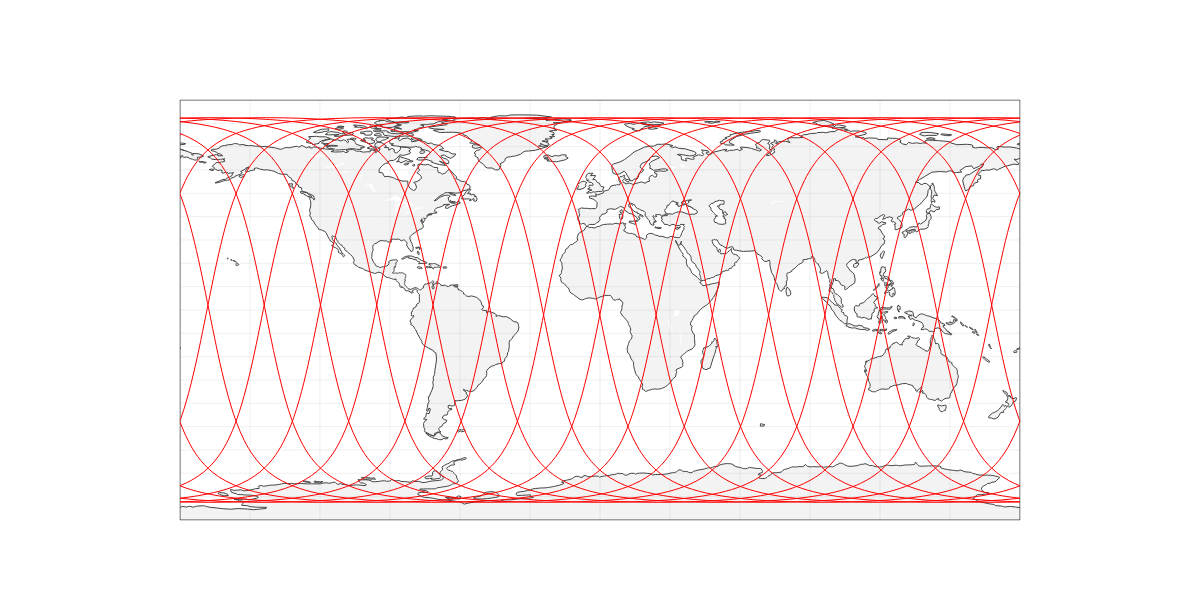

In [16]:
figure = create_2d_map(
    data=go.Scattergeo(
        lon=orbit_df["$Longitude$"],
        lat=orbit_df["$Latitude$"],
        mode="lines",
        line=go.scattergeo.Line(width=1, color="red"),
    ),
)
figure.layout.update(
    {
        "width": 1200,
        "height": 600,
    }
)

figure.show("png")

3D plot, in **Earth Fixed** frame:

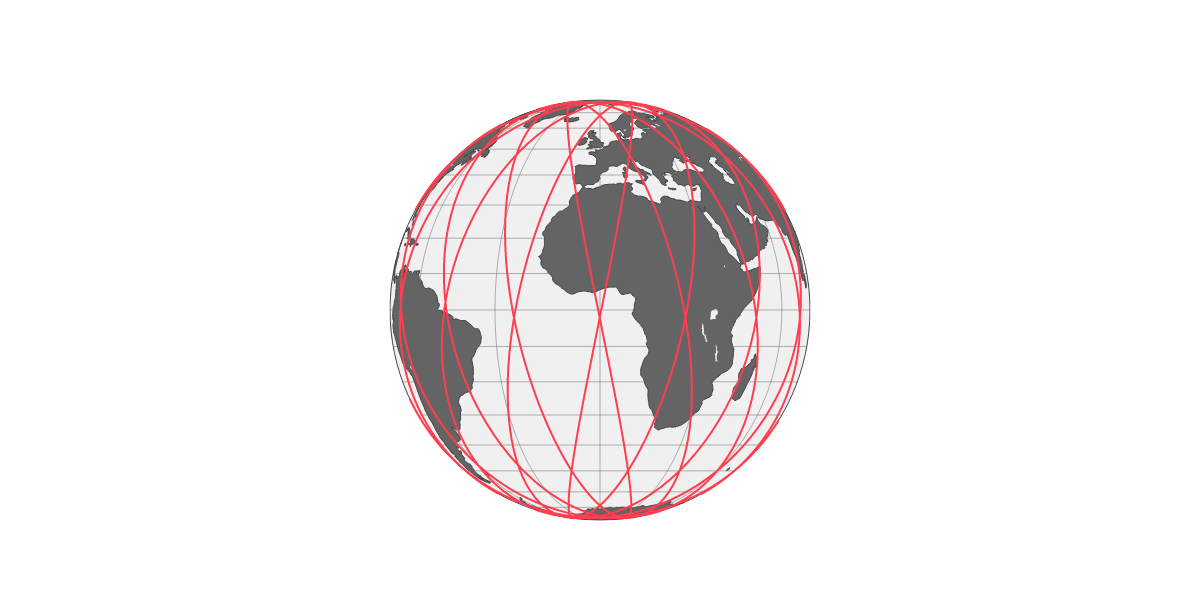

In [17]:
figure = create_3d_globe(
    data=[
        go.Scattergeo(
            lon=orbit_df["$Longitude$"],
            lat=orbit_df["$Latitude$"],
            mode="lines",
            line=go.scattergeo.Line(width=2, color="rgb(255, 62, 79)"),
        )
    ],
)
figure.layout.update(
    {
        "width": 1200,
        "height": 600,
    }
)

figure.show("png")

3D plot, in **Earth Inertial** frame:

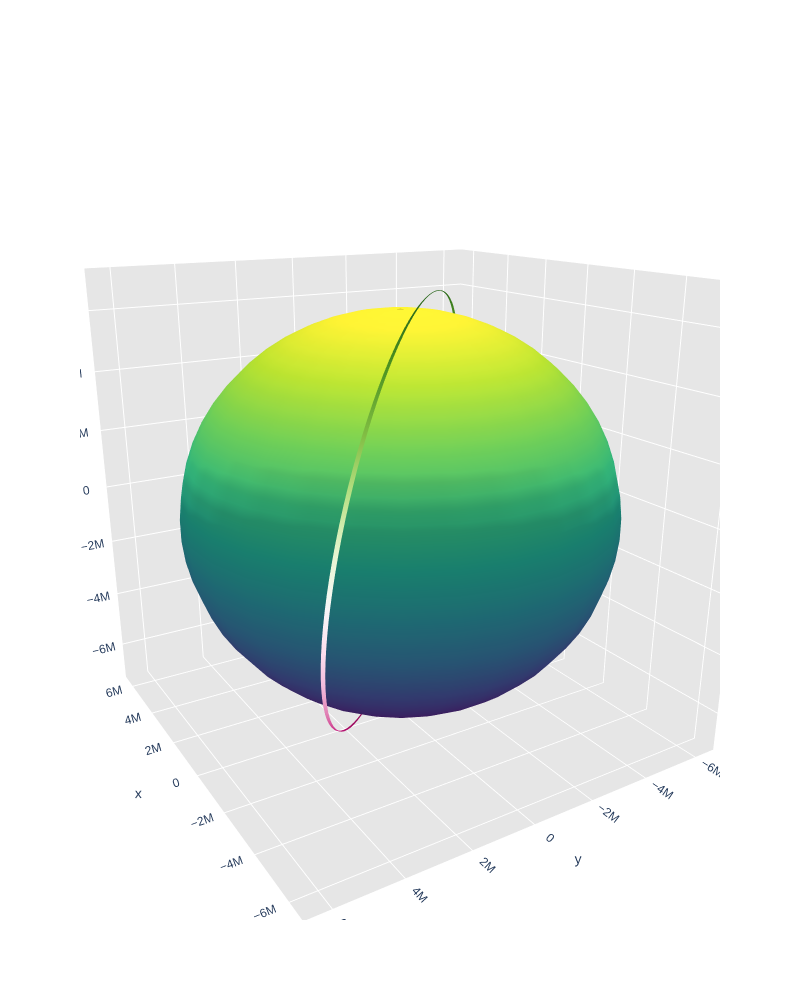

In [18]:
theta = np.linspace(0, 2 * np.pi, 30)
phi = np.linspace(0, np.pi, 30)

theta_grid, phi_grid = np.meshgrid(theta, phi)

r = float(earth.get_equatorial_radius().in_meters())

x = r * np.cos(theta_grid) * np.sin(phi_grid)
y = r * np.sin(theta_grid) * np.sin(phi_grid)
z = r * np.cos(phi_grid)

earth_surface = go.Surface(x=x, y=y, z=z, colorscale="Viridis", showscale=False)

trace = go.Scatter3d(
    x=orbit_df["$x_{x}^{ECI}$"],
    y=orbit_df["$x_{y}^{ECI}$"],
    z=orbit_df["$x_{z}^{ECI}$"],
    mode="lines",
    marker=dict(
        size=0, color=orbit_df["$x_{z}^{ECI}$"], colorscale="Viridis", showscale=False
    ),
    line=dict(color=orbit_df["$x_{z}^{ECI}$"], width=1),
)

figure = go.Figure(
    data=[earth_surface, trace],
    layout=go.Layout(
        title=None,
        width=800,
        height=1000,
        showlegend=False,
        scene=go.layout.Scene(
            xaxis=dict(
                gridcolor="rgb(255, 255, 255)",
                zerolinecolor="rgb(255, 255, 255)",
                showbackground=True,
                backgroundcolor="rgb(230, 230,230)",
            ),
            yaxis=dict(
                gridcolor="rgb(255, 255, 255)",
                zerolinecolor="rgb(255, 255, 255)",
                showbackground=True,
                backgroundcolor="rgb(230, 230,230)",
            ),
            zaxis=dict(
                gridcolor="rgb(255, 255, 255)",
                zerolinecolor="rgb(255, 255, 255)",
                showbackground=True,
                backgroundcolor="rgb(230, 230,230)",
            ),
            camera=dict(
                up=dict(x=0, y=0, z=1),
                eye=dict(
                    x=-1.7428,
                    y=1.0707,
                    z=0.7100,
                ),
            ),
            aspectratio=dict(x=1, y=1, z=1),
            aspectmode="manual",
        ),
    ),
)

figure.show("png")

---